#### IBM Applied Data Science Capstone
# Predicting land prices in Buenos Aires
*Ezequiel A. Pássaro*

✉ epassaro@carina.fcaglp.unlp.edu.ar

$~$

## 1. Introduction

Our main goal is to building a machine learning model for predicting land prices to help real state investors to make better business decisions.

### Objectives:

- Identify the most expensive neighborhoods through data analysis and visualization tools.
- Build a simple regression model for predicting land prices in the City of Buenos Aires.
- Improve our model by adding data through the Foursquare API.

### Data


This project was developed using open data provided by the City of Buenos Aires.
![](http://vivifrancia.com.ar/bsas/wp-content/uploads/sites/8/7.png)

- [Neighborhoods of Buenos Aires (GeoJSON)](https://data.buenosaires.gob.ar/dataset/barrios)
- [Land prices 2018 (CSV)](https://data.buenosaires.gob.ar/dataset/terrenos-valor-oferta)
- [Foursquare API](https://developer.foursquare.com/docs)

## 2. Neighborhoods of BA

What can we learn about Buenos Aires neighborhoods through the *Land prices* dataset?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import folium
import locale

In [2]:
df = pd.read_csv('./data/precio-de-terrenos-2018.csv')
df.head()

,operacion,tipo,lat,long,m2total,m2cub,direccion,cambio,preciousd,precioars,...,fot,zona,shape_leng,shape_area,calle,altura,barrio,comuna,codigo_postal,codigo_postal_argentino
0,VTA,TERRENO,-34.604655,-58.424276,209.0,627.0,SARMIENTO 4100,28.0,550000.0,15400000.0,...,NaN,CENTRO-ESTE,20683.699145,1.826166e+07,SARMIENTO,4100.0,ALMAGRO,5.0,1197.0,C1197AAH
1,VTA,TERRENO,-34.604252,-58.416767,463.0,644.0,MARIO BRAVO 467,28.0,1150000.0,32200000.0,...,2.5,CENTRO-ESTE,20683.699145,1.826166e+07,MARIO BRAVO,467.0,ALMAGRO,5.0,1175.0,C1175ABG
2,VTA,TERRENO,-34.615807,-58.420898,355.0,355.0,Belgrano 3800,28.0,360000.0,10080000.0,...,NaN,CENTRO-ESTE,20683.699145,1.826166e+07,Belgrano,3800.0,ALMAGRO,5.0,1210.0,C1210AAS
3,VTA,TERRENO,-34.617057,-58.416277,422.0,0.0,BOEDO 300,28.0,935000.0,26180000.0,...,NaN,CENTRO-ESTE,20683.699145,1.826166e+07,BOEDO,300.0,ALMAGRO,5.0,1206.0,C1206AAP
4,VTA,TERRENO,-34.603556,-58.413736,217.0,0.0,SANCHEZ DE BUSTAMANTE 500,28.0,700000.0,19600000.0,...,NaN,CENTRO-ESTE,20683.699145,1.826166e+07,SANCHEZ DE BUSTAMANTE,500.0,ALMAGRO,5.0,1173.0,C1173ABH


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 22 columns):
operacion                  325 non-null object
tipo                       325 non-null object
lat                        325 non-null float64
long                       325 non-null float64
m2total                    325 non-null float64
m2cub                      325 non-null float64
direccion                  324 non-null object
cambio                     325 non-null float64
preciousd                  325 non-null float64
precioars                  325 non-null float64
preciousdm                 325 non-null float64
precioarsm                 325 non-null float64
fot                        67 non-null float64
zona                       325 non-null object
shape_leng                 325 non-null float64
shape_area                 325 non-null float64
calle                      324 non-null object
altura                     282 non-null float64
barrio                     325 non-nu

We are interested in the following fields: **m2total** (*total square meters*), **barrio** (*neighborhood*) and **preciousdm** (*price per square meter in USD*). 

There are no missing values for these fields. We need to tweak neighborhood names to match the GeoJSON file.

In [4]:
df['barrio'] =  df['barrio'].str.upper()

With the help of *groupby* method we can find the *average price per square meter per neighborhood*.

In [5]:
mean_by_neighborhood = df.groupby('barrio').mean()[['preciousdm']]
mean_by_neighborhood.columns = ['mean_m2_usd']

# Save a dictionary for later use
my_dict = mean_by_neighborhood.to_dict()

mean_by_neighborhood.reset_index(inplace=True)
# The 10 most expensive neighborhoods.
mean_by_neighborhood.sort_values(by='mean_m2_usd', ascending=False).head(10)

,barrio,mean_m2_usd
26,RECOLETA,5968.899773
20,PALERMO,5465.384821
29,SAN NICOLAS,4692.325330
4,BELGRANO,4490.332117
10,COLEGIALES,3143.569846
2,BALVANERA,3139.383764
7,CABALLITO,2972.958717
30,SAN TELMO,2759.398496
33,VILLA CRESPO,2738.190883
1,ALMAGRO,2699.647873


A choroplet map would be perfect for this scenario!

In [6]:
map_ba = folium.Map(location=[-34.603722, -58.381592], zoom_start=12)

map_ba.choropleth(geo_data='./data/barrios.geojson', 
             key_on = 'feature.properties.BARRIO', 
             data = mean_by_neighborhood, 
             columns = ['barrio', 'mean_m2_usd'],
             fill_color = 'YlGn',
             fill_opacity = 0.7,
             line_opacity = 0.7,
             legend_name = 'Price per square meter in USD'
            )

Also add markers for the lands.

In [7]:
locale.setlocale(locale.LC_ALL, '')

for lat, long, m2total, preciousd in zip(df['lat'], df['long'], df['m2total'], df['preciousd']):
    
    label = 'Area: {} m² | Price: {}'.format(str(m2total)[:-2], locale.currency(preciousd, grouping=True)[:-3])
    label = folium.Popup(label)
    
    folium.CircleMarker(
        [lat, long],
        radius = 3,
        fill = True,
        fill_opacity = 0.5,
        popup = label,
        
    ).add_to(map_ba)  

In [8]:
map_ba

Beautiful!

## 2. Linear regression

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

plt.style.use('seaborn')

First, we make a couple of scatterplots to visualize how prices are related with the total area. It's easy to identify the outlier.

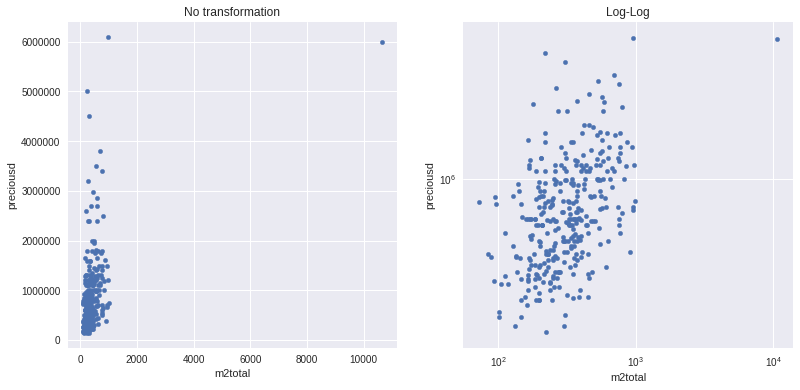

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
df.plot(kind='scatter', x='m2total', y='preciousd', title='No transformation', ax=ax1)
df.plot(kind='scatter', x='m2total', y='preciousd', title='Log-Log',loglog=True, ax=ax2)

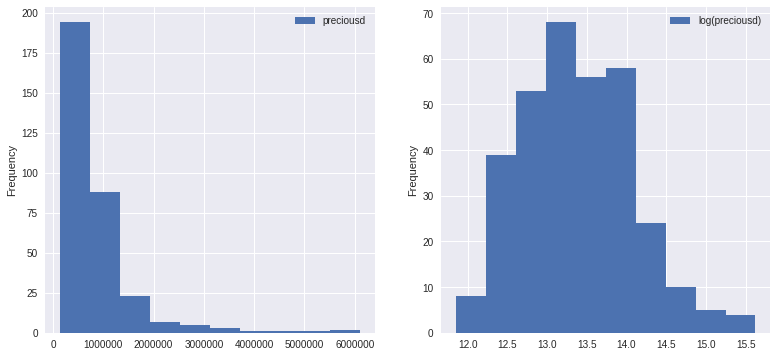

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
df.plot(kind='hist', y='preciousd', ax=ax1)
df['preciousd'].apply(np.log).plot(kind='hist', ax=ax2, label='log(preciousd)')
plt.legend()

Split the dataset and fit.

In [12]:
X = df[['m2total']]
y = df[['preciousd']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Evaluate the model. Why use RMSLE as metric? 

*"RMSLE penalizes an under-predicted estimate greater than an over-predicted estimate."* 

In [15]:
y_pred = lr.predict(X_test)

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 0.72'

Let's fit again in a log-log space (powerlaw).

In [16]:
lr.fit(X_train.apply(np.log), y_train.apply(np.log))
y_pred = lr.predict(X_test.apply(np.log))

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, np.exp(y_pred)))

'RMSLE: 0.67'

In [17]:
a,b = lr.coef_, lr.intercept_

Text(0, 0.5, 'preciousd')

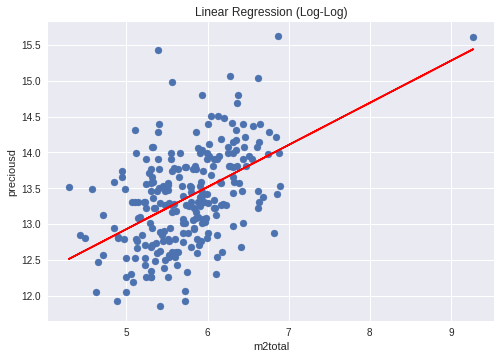

In [18]:
plt.scatter(X_train.apply(np.log), y_train.apply(np.log))
plt.plot(X_train.apply(np.log), X_train.apply(np.log)*a +b, c='red')
plt.title('Linear Regression (Log-Log)')
plt.xlabel('m2total')
plt.ylabel('preciousd')

## 3. Foursquare data

The idea is very simple: we define a function to search number of venues near a piece of land. Then we add it to our features and train a multi-linear regression model.

In [19]:
CLIENT_ID = '3SB2XVYJ0TXDQHFAWM12414LOWG4UJR3RTFRVMIAYJNNCSPW'
CLIENT_SECRET = '2NRHX3LHZRR3ZCC4F5YUBR0MNO0MP0VN03C3YKOQX133SG1Z'
VERSION = '20180604'
LIMIT = 1000
radius = 500

In [20]:
def venues_near(lat, long):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        long, 
        radius, 
        LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    
    return len(venues)

In [21]:
for i in range(df.shape[0]-1):
    df.loc[i, 'venues_near'] = venues_near(df['lat'][i], df['long'][i])

In [22]:
df.head()

,operacion,tipo,lat,long,m2total,m2cub,direccion,cambio,preciousd,precioars,...,zona,shape_leng,shape_area,calle,altura,barrio,comuna,codigo_postal,codigo_postal_argentino,venues_near
0,VTA,TERRENO,-34.604655,-58.424276,209.0,627.0,SARMIENTO 4100,28.0,550000.0,15400000.0,...,CENTRO-ESTE,20683.699145,1.826166e+07,SARMIENTO,4100.0,ALMAGRO,5.0,1197.0,C1197AAH,24.0
1,VTA,TERRENO,-34.604252,-58.416767,463.0,644.0,MARIO BRAVO 467,28.0,1150000.0,32200000.0,...,CENTRO-ESTE,20683.699145,1.826166e+07,MARIO BRAVO,467.0,ALMAGRO,5.0,1175.0,C1175ABG,63.0
2,VTA,TERRENO,-34.615807,-58.420898,355.0,355.0,Belgrano 3800,28.0,360000.0,10080000.0,...,CENTRO-ESTE,20683.699145,1.826166e+07,Belgrano,3800.0,ALMAGRO,5.0,1210.0,C1210AAS,19.0
3,VTA,TERRENO,-34.617057,-58.416277,422.0,0.0,BOEDO 300,28.0,935000.0,26180000.0,...,CENTRO-ESTE,20683.699145,1.826166e+07,BOEDO,300.0,ALMAGRO,5.0,1206.0,C1206AAP,17.0
4,VTA,TERRENO,-34.603556,-58.413736,217.0,0.0,SANCHEZ DE BUSTAMANTE 500,28.0,700000.0,19600000.0,...,CENTRO-ESTE,20683.699145,1.826166e+07,SANCHEZ DE BUSTAMANTE,500.0,ALMAGRO,5.0,1173.0,C1173ABH,38.0


Replace *NaN's* with 1.

In [23]:
df[ df['venues_near'].isna()]

,operacion,tipo,lat,long,m2total,m2cub,direccion,cambio,preciousd,precioars,...,zona,shape_leng,shape_area,calle,altura,barrio,comuna,codigo_postal,codigo_postal_argentino,venues_near
324,VTA,TERRENO,-34.632253,-58.359106,239.0,0.0,Aristobulo del Valle 300,28.0,267000.0,7476000.0,...,SUR,70129.883204,8.856643e+07,Aristobulo del Valle,300.0,BOCA,4.0,1160.0,C1160ADF,NaN


In [24]:
df['venues_near'].fillna(1, inplace=True)
df[ df['venues_near'].isna()]

,operacion,tipo,lat,long,m2total,m2cub,direccion,cambio,preciousd,precioars,...,zona,shape_leng,shape_area,calle,altura,barrio,comuna,codigo_postal,codigo_postal_argentino,venues_near


In [25]:
X = df[['m2total', 'venues_near']]
y = df[['preciousd']]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, y_pred))

'RMSLE: 0.62'

Let's fit again in a log-log space (powerlaw).

In [27]:
lr.fit(X_train.apply(np.log), y_train.apply(np.log))
y_pred = lr.predict(X_test.apply(np.log))

'RMSLE: %.2f' % np.sqrt(mean_squared_log_error(y_test, np.exp(y_pred)))

'RMSLE: 0.53'

## 4. Results

| Model (Features) | No transform | Log-Log |
|------------------|--------------|-------- |
|   Linear Regression (*'m2total'*) | 0.72 | 0.67 |
|   Multilinear Regression (*'m2total', 'venues_near'*)  | 0.60 | 0.53 |